# Fourier Picture from SVG file

Some remarks to start with:
You can create an SVG file (https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) with many grafic programs. I used GIMP to draw the outline of my silhouette from a picture in profile. For a simple guide how to draw the path and how to export is as an SVG file in GIMP look for example here: https://www.useragentman.com/blog/2013/04/26/how-to-create-svg-paths-easily-using-the-gimp/

The SVG file stores the path in terms of path segments which consist of cubic Bezier curves. If you want to learn a bit about Bezier curves, here is a really nice YouTube video: https://www.youtube.com/watch?v=aVwxzDHniEw

With svgpathtools Python offers a really nice and extensive library taking care of almost everything one would like to do with SVG files. I also use matplotlib to generate the final animation. os is a library which helps you interacting with the operating system. I use it to check whether a file exists already and to delete it if necessary.

So, let's import the necessary libraries

In [1]:
import numpy as np
from svgpathtools import svg2paths, wsvg
from svgpathtools.path import CubicBezier
import matplotlib.pyplot as pl 
from matplotlib import animation
import os

kjl

In [2]:
pict1 = "/Users/christophstephan/Desktop/Kunst und so/Fourierkunst/KathiPfad.svg"
pict2 = "/Users/christophstephan/Desktop/Kunst und so/Fourierkunst/CAS.svg"

paths1, attributes1 = svg2paths(pict1)
paths2, attributes2 = svg2paths(pict2)

In [3]:
xes = []
vals = np.linspace(0, 1, 20)
rate = 1

In [4]:
print(paths1[0].start,paths2[0].end)

(620+1060j) (84.5+892j)


In [5]:
for path in paths2[0]:
    
    # find third order polynomial, s.t. polynomial(0) = start of path segment and polynomial(1) = end of path segment
    # luckily .poly() does the trick for cubic Bezier curves :-)
    pathpolynomial = path.poly()
    
    # get 20 points in the complex plane along the path from the polynomial using the values from linspace
    points = pathpolynomial(vals)
    
    # use the clever numpy c_ function to build a list of the compex points representes as 2-element lists 
    # of real and imaginary part
    points = np.c_[points.real, points.imag]
    
    # approximate the length of each path by summing over the distances between the 20 base points
    length = points[1:] - points[:-1]
    length = int(np.sqrt((length * length).sum()))
    
    # build a linspace to reduce the number of basepoints to a managable amount using the "sampling" rate
    reducedpoints = np.linspace(0, 1, int(length / rate) + 1, endpoint=False)
    
    # collect the reduced number of basepoints into a list
    xes.extend(pathpolynomial(reducedpoints))
    
print(len(xes),xes[0],xes[len(xes)-1])
    

735 (81+888j) (85.37448559670781+892.7544581618656j)


In [6]:
# build a plottable array from the points
xx = np.asarray(xes)
# shift to zero
xx -= xx.mean(0)
# scale to 1
scale = max(np.abs(xx.real).max(), np.abs(xx.imag).max())
xx /= scale
# image is upside down. So reflect on real axis
xx = xx.real - 1j * xx.imag

(-0.7538927186929464,
 0.7965938945507018,
 -1.098733319120767,
 1.0670006849316525)

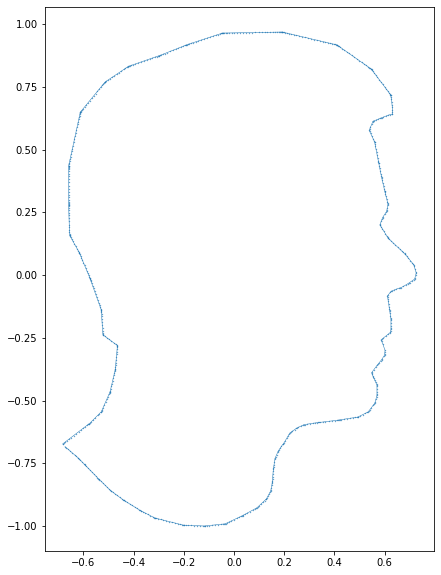

In [7]:
# let's have a look what we have...
pl.figure(figsize=(10, 10))
pl.scatter(xx.real, xx.imag,s=0.1)
pl.plot(xx.real, xx.imag, lw=0.5)
pl.axis('scaled')

In [8]:
# calculate and normalise fourier coefficients
Fxx    = np.fft.fft(xx) / xx.size
# calculate fourier frequencies
frequencies = np.fft.fftfreq(Fxx.size, 1/Fxx.size)
# calculate absolute values, i.e. radii of circles
radii = np.abs(Fxx)

In [9]:
# just check the maximal radius
radii.max()

0.8070900033929865

In [10]:
# we probably have too many fourier coefficients
len(Fxx)

735

In [12]:
# first, get the list of indices of the entries in radii from biggest to smallest
inds = np.argsort(-radii)
# define a list with the normalised radii
rad_norm = radii / radii.sum()
# build a list with partial sums (cumsum) of the first n biggest entries
rad_norm = np.cumsum(rad_norm[inds])
# find the number N of Fourier coefficients, s.t. the partial sum is below a threshold
#N = (rad_norm < 0.91).sum() + 1
N = 50 

In [13]:
# now find the top N indeces 
top_inds = (inds[:N])
top_inds = top_inds[top_inds != 0]

In [14]:
# select the corresponding fourier coefficients, radii and frequencies
Fxx_sel = Fxx[top_inds]
radii_sel = radii[top_inds]
freq_sel = frequencies[top_inds]

In [15]:
len(Fxx_sel)

50

In [16]:
# fix the center of the first fourier epicycle
#base = Fxx_sel[0]
# time points
#time = list(enumerate(np.linspace(0, 2 * np.pi, 100)))
# linspace for points on the fourier circles
theta = np.linspace(-np.pi, np.pi, N)
points = []

In [16]:
def plotfig(t):
    base = Fxx_sel[0]
    pl.clf()
    #pl.plot(xx.real, xx.imag, lw=0.5)
    for count, (Fxx_i, rad_i, freq_i) in enumerate(zip(Fxx_sel, radii_sel, freq_sel)):
        # find point on epicycle at time t
        r_i = Fxx_i * np.exp(1j * freq_i * t) 
        # draw center of epicycle
        pl.scatter([base.real], [base.imag], c= 'blue', s=0.1,lw=0.1)
        # build list with points on circle of epicycle 
        xy = np.c_[np.cos(theta) * rad_i + base.real, np.sin(theta) * rad_i + base.imag]
        # plot circle
        pl.plot(xy[:, 0], xy[:, 1], c= 'blue', lw=0.1)
        # plot line from center of circle to r_i
        pl.plot([base.real, base.real + r_i.real], [base.imag, base.imag + r_i.imag], c='blue', lw=0.1)
        # shift to center of next epicycle
        base += r_i
        pl.xticks([])
        pl.yticks([])
        pl.xlim((-2, 2))
        pl.ylim((-2, 2))
        pl.axis('off')

    points.append(base)
    pl.scatter([base.real], [base.imag], c='red')
    pp = np.asarray(points)
    pl.plot(pp.real, pp.imag, lw=0.5)
    

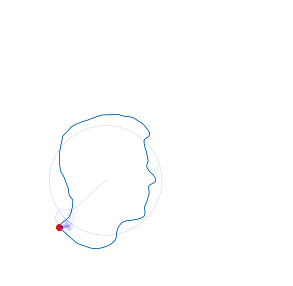

In [17]:
gifname = '/Users/christophstephan/Desktop/Kunst und so/Fourierkunst/anim/fourier.gif'

n_frames = 200 

fig, ax = pl.subplots(1, 1, figsize=(5, 5))

anim = animation.FuncAnimation(
        fig=fig,    
        func=plotfig, 
        frames=np.linspace(0, 4 * np.pi, n_frames), 
        interval=20,
    )

if os.path.isfile(gifname):
   os.remove(gifname)

anim.save(gifname, writer='imagemagick',fps = 20)

pl.show()
pl.clf()
pl.close()

In [23]:
radii_sel.min()

0.00024381421289790164

In [26]:
for f in freq_sel:
    print(str(int(f)))

-3
-4
-2
-6
1
4
3
-1
5
-9
-8
6
-5
-13
-7
2
10
13
-11
11
-18
-12
-15
16
-10
-20
-14
22
-23
9
-24
-17
17
-16
7
19
18
8
20
24
-27
-19
27
-32
-35
-21
31
33
34
30
-44
-28
-31
12
32
-26
41
42
35
25
23
-34
-49
-33
-36
-22
28
-39
29
36
46
14
-25
-40
-37
47
-46
45
-50
51
-38
26
38
39
48
50
21
59
-30
40
53
65
-47
55
49
-53
66
-51
76
-75
-77
-43
64
-41
69
15
84
-52
37
62
-59
52
-45
-64
44
70
-42
71
56
60
90
72
68
61
-56
67
-73
-48
75
-55
43
91
92
58
73
-60
85
80
-79
-81
-57
-66
-71
81
-88
-85
-70
-102
86
78
-89
-83
104
105
97
-100
-86
83
-62
115
-93
-104
63
89
-72
-103
-74
-82
-105
103
-95
93
-87
-137
121
-120
-67
145
-69
-90
-121
88
-92
102
138
107
-94
96
-109
119
-122
144
-63
111
-108
-78
-150
131
79
-68
-106
94
108
-139
-127
112
-29
82
-155
114
120
132
-115
-114
-107
137
54
57
109
-125
116
-65
-119
135
99
98
146
157
-172
-61
126
-177
155
164
-54
-166
122
-101
-132
162
-76
161
100
-174
87
-84
139
-131
143
-135
-189
-126
191
129
212
113
151
-110
-80
-96
-97
-111
-159
-138
-123
-99
211
-133
136
-

In [27]:
for f in radii_sel:
    print(str(f))

0.3666638714356495
0.28219903258967505
0.22669339582365486
0.12166946966587103
0.08479822235726066
0.07463924990682631
0.07342942956257961
0.07264575312247991
0.0476603804981622
0.041851918253196334
0.040577967638912214
0.04034228003302818
0.03660900496423854
0.03439067484296454
0.03376360239702638
0.0329208881739144
0.026724185119210805
0.02622199404875849
0.02222593684939599
0.021238749963273056
0.02087602304994602
0.019886863015540254
0.019438336372995434
0.018007870225799597
0.0168964853241195
0.01664502379547428
0.016147193530865404
0.015938575926023
0.015405718456167089
0.014997120361131853
0.01485252793076281
0.014368279594602525
0.013947312260466894
0.012403966496106795
0.012145056836087756
0.011720702432445948
0.01171381442226466
0.01160579303780139
0.010306676429291185
0.010081179532277752
0.009996148226481913
0.009976838052552804
0.009769968329859016
0.00834298338104404
0.008200718317957798
0.007952941385698615
0.007935759226265666
0.007910869653107762
0.007558634096708492
0

In [17]:
fourierstring = '\mathcal{F}_{N}(\mathcal{KJF}) =& '
for count, (x,y) in enumerate(zip(radii_sel,freq_sel)):
    r = str(round(x,6))
    p = str(int(y))
    
    if count != 0 and count % 7 == 0:
        fourierstring = fourierstring + '\\nonumber \\\ & +' + r + '\cdot e^{'+ p +'i  t}'
    else:
        fourierstring = fourierstring + ' +' + r + '\cdot e^{'+ p +'i  t}'
        

In [18]:
print(fourierstring)

\mathcal{F}_{N}(\mathcal{KJF}) =&  +0.80709\cdot e^{-1i  t} +0.129563\cdot e^{1i  t} +0.06092\cdot e^{-3i  t} +0.038052\cdot e^{-2i  t} +0.037734\cdot e^{3i  t} +0.033712\cdot e^{2i  t} +0.030751\cdot e^{-5i  t}\nonumber \\ & +0.0276\cdot e^{-4i  t} +0.016359\cdot e^{4i  t} +0.0162\cdot e^{7i  t} +0.015545\cdot e^{6i  t} +0.01406\cdot e^{5i  t} +0.00938\cdot e^{-8i  t} +0.008327\cdot e^{-9i  t}\nonumber \\ & +0.007809\cdot e^{8i  t} +0.007608\cdot e^{-7i  t} +0.007439\cdot e^{9i  t} +0.006151\cdot e^{10i  t} +0.005816\cdot e^{14i  t} +0.005105\cdot e^{-12i  t} +0.004698\cdot e^{-17i  t}\nonumber \\ & +0.004584\cdot e^{-10i  t} +0.004349\cdot e^{11i  t} +0.004179\cdot e^{-14i  t} +0.003902\cdot e^{-15i  t} +0.003304\cdot e^{17i  t} +0.003238\cdot e^{-16i  t} +0.00301\cdot e^{12i  t}\nonumber \\ & +0.002958\cdot e^{-11i  t} +0.002843\cdot e^{-20i  t} +0.002837\cdot e^{16i  t} +0.002826\cdot e^{15i  t} +0.002501\cdot e^{20i  t} +0.002463\cdot e^{-22i  t} +0.002375\cdot e^{-6i  t}\nonumber